In [2]:
#공통 인코
import json, torch, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ===== 설정 =====
HOME = Path.home()
DATA_PATH = HOME / "Desktop" / "결과_매수매도_학습" / "preprocessed.json"
MODEL_NAME = "snunlp/KR-FinBERT-SC"
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 1. 데이터 로드 =====
with open(DATA_PATH, encoding="utf-8") as f:
    data = json.load(f)
X_text, y = data["texts"], data["labels"]

# Stratified Split
X_train_txt, X_val_txt, y_train, y_val = train_test_split(
    X_text, y, test_size=0.1, random_state=42, stratify=y, shuffle=True
)

# ===== 2. FinBERT 인코더 고정 및 임베딩 추출 함수 =====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# ★ 핵심: 모델 고정 (Freeze)
for param in bert_model.parameters():
    param.requires_grad = False
bert_model.eval()

def get_embeddings(texts, batch_size=32):
    all_embeddings = []
    # 메모리 절약을 위해 배치 단위 처리
    for i in tqdm(range(0, len(texts), batch_size), desc="임베딩 추출 중"):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = bert_model(**inputs)
            # CLS 토큰(문장 전체의 의미) 벡터 추출 (Batch, 768)
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_emb)
            
    return np.vstack(all_embeddings)

print(">>> 훈련 데이터 임베딩 추출 시작...")
X_train_emb = get_embeddings(X_train_txt, BATCH_SIZE)
print(">>> 검증 데이터 임베딩 추출 시작...")
X_val_emb = get_embeddings(X_val_txt, BATCH_SIZE)

print(f"추출 완료: Train shape {X_train_emb.shape}, Val shape {X_val_emb.shape}")

>>> 훈련 데이터 임베딩 추출 시작...


임베딩 추출 중: 100%|██████████| 132/132 [00:43<00:00,  3.01it/s]


>>> 검증 데이터 임베딩 추출 시작...


임베딩 추출 중: 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

추출 완료: Train shape (4203, 768), Val shape (468, 768)


In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

print("\n===== [1] XGBoost 학습 시작 (tuned) =====")

xgb = XGBClassifier(
    # 구조
    n_estimators=1200,          # 트리 개수 ↑ (learning_rate 줄였으니 많이 써도 됨)
    learning_rate=0.03,         # 한 스텝씩 더 부드럽게
    max_depth=4,                # 트리 깊이 ↓ (과적합 줄이기)
    min_child_weight=3,         # 리프에 최소 가중치 → 너무 잘게 안 쪼개게
    gamma=0.5,                  # 분할할 때 이득이 충분히 클 때만 쪼개기

    # 서브샘플링(규제 + 일반화)
    subsample=0.8,              # 샘플 서브샘플
    colsample_bytree=0.8,       # 피처 서브샘플

    # L2 / L1 규제
    reg_lambda=1.0,             # L2
    reg_alpha=0.0,              # L1 (나중에 더 줄이고 싶으면 0.1~0.5도 시도 가능)

    # 기타
    objective="binary:logistic",
    eval_metric="logloss",      # 명시적으로 고정
    random_state=42,
    n_jobs=-1,
    tree_method="hist",         # CPU에서 빠르게 (지원 안 되면 지워도 됨)
    early_stopping_rounds=50    # 더 여유 있게 모니터링
)

xgb.fit(
    X_train_emb, y_train,
    eval_set=[(X_val_emb, y_val)],
    verbose=True
)

# 평가
preds = xgb.predict(X_val_emb)
print(f"XGBoost Accuracy: {accuracy_score(y_val, preds):.4f}")
print(f"XGBoost F1 Score: {f1_score(y_val, preds, average='macro'):.4f}")



===== [1] XGBoost 학습 시작 (tuned) =====
[0]	validation_0-logloss:0.68624
[1]	validation_0-logloss:0.67907
[2]	validation_0-logloss:0.67243
[3]	validation_0-logloss:0.66610
[4]	validation_0-logloss:0.65999
[5]	validation_0-logloss:0.65441
[6]	validation_0-logloss:0.65000
[7]	validation_0-logloss:0.64485
[8]	validation_0-logloss:0.64001
[9]	validation_0-logloss:0.63524
[10]	validation_0-logloss:0.63135
[11]	validation_0-logloss:0.62699
[12]	validation_0-logloss:0.62315
[13]	validation_0-logloss:0.61953
[14]	validation_0-logloss:0.61599
[15]	validation_0-logloss:0.61202
[16]	validation_0-logloss:0.60827
[17]	validation_0-logloss:0.60518
[18]	validation_0-logloss:0.60189
[19]	validation_0-logloss:0.59921
[20]	validation_0-logloss:0.59662
[21]	validation_0-logloss:0.59391
[22]	validation_0-logloss:0.59159
[23]	validation_0-logloss:0.58953
[24]	validation_0-logloss:0.58722
[25]	validation_0-logloss:0.58461
[26]	validation_0-logloss:0.58188
[27]	validation_0-logloss:0.57977
[28]	validation_0-l

In [3]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

print("\n===== [2] MLP (Deep Neural Net) 학습 시작 =====")

# 데이터셋 변환 (Numpy -> Tensor)
train_ds = TensorDataset(torch.tensor(X_train_emb, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(X_val_emb, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# MLP 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=768, num_classes=2):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

model_mlp = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_mlp.parameters(), lr=1e-3)

# 학습 루프
epochs = 10
best_acc = 0

for epoch in range(epochs):
    model_mlp.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model_mlp(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
    # 검증
    model_mlp.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            outputs = model_mlp(xb)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(yb.numpy())
            
    acc = accuracy_score(val_targets, val_preds)
    print(f"Epoch {epoch+1}/{epochs} - Val Acc: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model_mlp.state_dict(), str(HOME / "Desktop" / "결과_매수매도_학습" / "best_mlp.pt"))

print(f"MLP Best Accuracy: {best_acc:.4f}")


===== [2] MLP (Deep Neural Net) 학습 시작 =====
Epoch 1/10 - Val Acc: 0.7457
Epoch 2/10 - Val Acc: 0.7094
Epoch 3/10 - Val Acc: 0.7735
Epoch 4/10 - Val Acc: 0.7585
Epoch 5/10 - Val Acc: 0.6966
Epoch 6/10 - Val Acc: 0.7415
Epoch 7/10 - Val Acc: 0.7415
Epoch 8/10 - Val Acc: 0.7543
Epoch 9/10 - Val Acc: 0.7308
Epoch 10/10 - Val Acc: 0.7585
MLP Best Accuracy: 0.7735


In [9]:
import xgboost
print(xgboost.__version__)


3.0.0


>>> 훈련 데이터 임베딩 추출 시작...


임베딩 추출 중: 100%|██████████| 132/132 [00:43<00:00,  3.02it/s]


>>> 검증 데이터 임베딩 추출 시작...


임베딩 추출 중: 100%|██████████| 15/15 [00:04<00:00,  3.07it/s]

추출 완료: Train shape (4203, 768), Val shape (468, 768)

===== [1] XGBoost 학습 시작 (tuned) =====
[0]	validation_0-logloss:0.68624
[1]	validation_0-logloss:0.67907
[2]	validation_0-logloss:0.67243
[3]	validation_0-logloss:0.66610


[4]	validation_0-logloss:0.65999
[5]	validation_0-logloss:0.65441
[6]	validation_0-logloss:0.65000
[7]	validation_0-logloss:0.64485
[8]	validation_0-logloss:0.64001
[9]	validation_0-logloss:0.63524
[10]	validation_0-logloss:0.63135
[11]	validation_0-logloss:0.62699
[12]	validation_0-logloss:0.62315
[13]	validation_0-logloss:0.61953
[14]	validation_0-logloss:0.61599
[15]	validation_0-logloss:0.61202
[16]	validation_0-logloss:0.60827
[17]	validation_0-logloss:0.60518
[18]	validation_0-logloss:0.60189
[19]	validation_0-logloss:0.59921
[20]	validation_0-logloss:0.59662
[21]	validation_0-logloss:0.59391
[22]	validation_0-logloss:0.59159
[23]	validation_0-logloss:0.58953
[24]	validation_0-logloss:0.58722
[25]	validation_0-logloss:0.58461
[26]	validation_0-logloss:0.58188
[27]	validation_0-logloss:0.57977
[28]	validation_0-logloss:0.57763
[29]	validation_0-logloss:0.57557
[30]	validation_0-logloss:0.57368
[31]	validation_0-logloss:0.57171
[32]	validation_0-logloss:0.57009
[33]	validation_0-lo

임베딩 추출 중: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


--- 전체 성능 (상향/하향 폴더) ---
Accuracy : 0.7889
F1-macro : 0.7844

===== 상세 리포트 =====
              precision    recall  f1-score   support

       하향(0)       0.72      0.93      0.82        45
       상향(1)       0.91      0.64      0.75        45

    accuracy                           0.79        90
   macro avg       0.82      0.79      0.78        90
weighted avg       0.82      0.79      0.78        90


상향(1) 정확도: 0.6444
하향(0) 정확도: 0.9333



C:\Users\bsbcn\AppData\Local\Temp\ipykernel_25884\1569537724.py:225: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsbcn\AppData\Local\Temp\ipykernel_25884\1569537724.py:225: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsbcn\AppData\Local\Temp\ipykernel_25884\1569537724.py:225: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsbcn\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\bsbcn\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\bsbcn\anaconda3\Lib\site-packages\IPython\core\pylabtools.

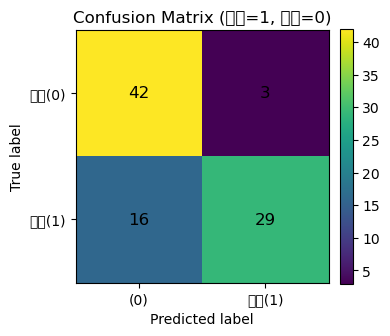


✅ 개별 파일별 예측 결과 저장: C:\Users\bsbcn\Desktop\분류\xgb_eval_result.csv


In [16]:
# ======================================
# 0. 공통 import & 설정 xg부스트 시각화
# ======================================
import json, torch, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import pandas as pd

# ===== 설정 =====
HOME = Path.home()
DATA_PATH = HOME / "Desktop" / "결과_매수매도_학습" / "preprocessed.json"
MODEL_NAME = "snunlp/KR-FinBERT-SC"
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================
# 1. 학습 데이터 로드 (preprocessed.json)
# ======================================
with open(DATA_PATH, encoding="utf-8") as f:
    data = json.load(f)

X_text, y = data["texts"], data["labels"]

# Stratified Split
X_train_txt, X_val_txt, y_train, y_val = train_test_split(
    X_text, y, test_size=0.1, random_state=42, stratify=y, shuffle=True
)

# ======================================
# 2. FinBERT 인코더 준비 & 임베딩 함수
# ======================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# ★ 모델 고정 (Freeze)
for param in bert_model.parameters():
    param.requires_grad = False
bert_model.eval()

def get_embeddings(texts, batch_size=32):
    """문장 리스트를 FinBERT CLS 임베딩 (np.array)로 변환"""
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="임베딩 추출 중"):
        batch_texts = texts[i : i + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)
            # CLS 토큰 벡터 (Batch, 768)
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_emb)

    return np.vstack(all_embeddings)

# ======================================
# 3. 학습/검증 임베딩 추출
# ======================================
print(">>> 훈련 데이터 임베딩 추출 시작...")
X_train_emb = get_embeddings(X_train_txt, BATCH_SIZE)

print(">>> 검증 데이터 임베딩 추출 시작...")
X_val_emb = get_embeddings(X_val_txt, BATCH_SIZE)

print(f"추출 완료: Train shape {X_train_emb.shape}, Val shape {X_val_emb.shape}")

# ======================================
# 4. XGBoost 학습 (튜닝된 하이퍼파라미터)
# ======================================
print("\n===== [1] XGBoost 학습 시작 (tuned) =====")

xgb = XGBClassifier(
    # 구조
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=4,
    min_child_weight=3,
    gamma=0.5,

    # 서브샘플링(규제 + 일반화)
    subsample=0.8,
    colsample_bytree=0.8,

    # L2 / L1 규제
    reg_lambda=1.0,
    reg_alpha=0.0,

    # 기타
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",   # 안 되면 이 줄만 주석 처리
)

xgb.fit(
    X_train_emb, y_train,
    eval_set=[(X_val_emb, y_val)],
    verbose=True
)

# 검증셋 평가
preds_val = xgb.predict(X_val_emb)
print("\n===== [2] 검증 세트 성능 =====")
print(f"XGBoost Accuracy: {accuracy_score(y_val, preds_val):.4f}")
print(f"XGBoost F1 Score: {f1_score(y_val, preds_val, average='macro'):.4f}")

# ======================================
# 5. 바탕화면/분류/상향·하향 폴더 평가
#    상향 = 1(매수), 하향 = 0(매도)
# ======================================
print("\n===== [3] 폴더 기반 평가 (상향=1, 하향=0) =====")

BASE_DIR = HOME / "Desktop" / "분류"
POS_DIR = BASE_DIR / "상향"   # label 1
NEG_DIR = BASE_DIR / "하향"   # label 0

texts = []
y_true = []
filenames = []
true_folder = []

# 상향(1) 파일들
if POS_DIR.exists():
    for path in sorted(POS_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(1)
        filenames.append(path.name)
        true_folder.append("상향")

# 하향(0) 파일들
if NEG_DIR.exists():
    for path in sorted(NEG_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(0)
        filenames.append(path.name)
        true_folder.append("하향")

texts = np.array(texts)
y_true = np.array(y_true)

print(f"폴더에서 불러온 샘플 수: {len(texts)}")

if len(texts) == 0:
    print("⚠ 상향/하향 폴더에 텍스트 파일이 없습니다.")
else:
    # 5-1) 폴더 텍스트 임베딩
    print(">>> 폴더 텍스트 임베딩 추출 시작...")
    X_folder_emb = get_embeddings(list(texts), BATCH_SIZE)

    # 5-2) 예측
    y_pred = xgb.predict(X_folder_emb)
    probs = xgb.predict_proba(X_folder_emb)

    # 5-3) 성능 지표
    acc_folder = accuracy_score(y_true, y_pred)
    f1_folder = f1_score(y_true, y_pred, average="macro")

    print("\n--- 전체 성능 (상향/하향 폴더) ---")
    print(f"Accuracy : {acc_folder:.4f}")
    print(f"F1-macro : {f1_folder:.4f}\n")

    print("===== 상세 리포트 =====")
    print(classification_report(y_true, y_pred, target_names=["하향(0)", "상향(1)"]))

    # 클래스별 정확도
    pos_mask = (y_true == 1)
    neg_mask = (y_true == 0)
    pos_acc = (y_pred[pos_mask] == y_true[pos_mask]).mean() if pos_mask.any() else np.nan
    neg_acc = (y_pred[neg_mask] == y_true[neg_mask]).mean() if neg_mask.any() else np.nan

    print(f"\n상향(1) 정확도: {pos_acc:.4f}" if not np.isnan(pos_acc) else "상향 샘플 없음")
    print(f"하향(0) 정확도: {neg_acc:.4f}" if not np.isnan(neg_acc) else "하향 샘플 없음")

    # ======================================
    # 6. 혼동행렬 시각화
    # ======================================
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title("Confusion Matrix (상향=1, 하향=0)")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["(0)", "상향(1)"])
    ax.set_yticklabels(["하향(0)", "상향(1)"])

    # 셀 숫자 표시
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center", fontsize=12,
            )

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # ======================================
    # 7. 개별 결과 CSV로 저장
    # ======================================
    df_result = pd.DataFrame({
        "filename": filenames,
        "true_folder": true_folder,
        "true_label": y_true,
        "pred_label": y_pred,
        "prob_0": probs[:, 0],
        "prob_1": probs[:, 1],
    })

    out_path = BASE_DIR / "xgb_eval_result.csv"
    df_result.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"\n✅ 개별 파일별 예측 결과 저장: {out_path}")



===== [3] 폴더 기반 평가 (상향=1, 하향=0) =====
폴더에서 불러온 샘플 수: 90
>>> 폴더 텍스트 임베딩 추출 시작...


임베딩 추출 중: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


--- 전체 성능 (상향/하향 폴더) ---
Accuracy : 0.7889
F1-macro : 0.7844

===== 상세 리포트 =====
              precision    recall  f1-score   support

       하향(0)       0.72      0.93      0.82        45
       상향(1)       0.91      0.64      0.75        45

    accuracy                           0.79        90
   macro avg       0.82      0.79      0.78        90
weighted avg       0.82      0.79      0.78        90


상향(1) 정확도: 0.6444
하향(0) 정확도: 0.9333


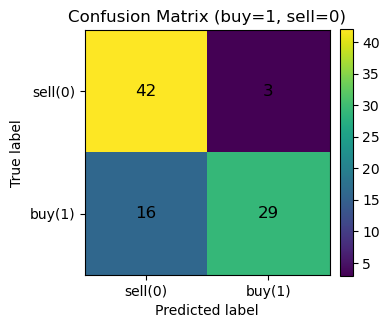


✅ 개별 파일별 예측 결과 저장: C:\Users\bsbcn\Desktop\분류\xgb_eval_result.csv


In [22]:
# ======================================
# 5. 바탕화면/분류/상향·하향 폴더 평가
#    상향 = 1(매수), 하향 = 0(매도)
# ======================================
print("\n===== [3] 폴더 기반 평가 (상향=1, 하향=0) =====")

BASE_DIR = HOME / "Desktop" / "분류"
POS_DIR = BASE_DIR / "상향"   # label 1
NEG_DIR = BASE_DIR / "하향"   # label 0

texts = []
y_true = []
filenames = []
true_folder = []

# 상향(1) 파일들
if POS_DIR.exists():
    for path in sorted(POS_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(1)
        filenames.append(path.name)
        true_folder.append("상향")

# 하향(0) 파일들
if NEG_DIR.exists():
    for path in sorted(NEG_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(0)
        filenames.append(path.name)
        true_folder.append("하향")

texts = np.array(texts)
y_true = np.array(y_true)

print(f"폴더에서 불러온 샘플 수: {len(texts)}")

if len(texts) == 0:
    print("⚠ 상향/하향 폴더에 텍스트 파일이 없습니다.")
else:
    # 5-1) 폴더 텍스트 임베딩
    print(">>> 폴더 텍스트 임베딩 추출 시작...")
    X_folder_emb = get_embeddings(list(texts), BATCH_SIZE)

    # 5-2) 예측
    y_pred = xgb.predict(X_folder_emb)
    probs = xgb.predict_proba(X_folder_emb)

    # 5-3) 성능 지표
    acc_folder = accuracy_score(y_true, y_pred)
    f1_folder = f1_score(y_true, y_pred, average="macro")

    print("\n--- 전체 성능 (상향/하향 폴더) ---")
    print(f"Accuracy : {acc_folder:.4f}")
    print(f"F1-macro : {f1_folder:.4f}\n")

    print("===== 상세 리포트 =====")
    print(classification_report(y_true, y_pred, target_names=["하향(0)", "상향(1)"]))

    # 클래스별 정확도
    pos_mask = (y_true == 1)
    neg_mask = (y_true == 0)
    pos_acc = (y_pred[pos_mask] == y_true[pos_mask]).mean() if pos_mask.any() else np.nan
    neg_acc = (y_pred[neg_mask] == y_true[neg_mask]).mean() if neg_mask.any() else np.nan

    print(f"\n상향(1) 정확도: {pos_acc:.4f}" if not np.isnan(pos_acc) else "상향 샘플 없음")
    print(f"하향(0) 정확도: {neg_acc:.4f}" if not np.isnan(neg_acc) else "하향 샘플 없음")

    # ======================================
    # 6. 혼동행렬 시각화
    # ======================================
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title("Confusion Matrix (buy=1, sell=0)")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["sell(0)", "buy(1)"])
    ax.set_yticklabels(["sell(0)", "buy(1)"])

    # 셀 숫자 표시
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i, cm[i, j],
                ha="center", va="center", fontsize=12,
            )

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    # ======================================
    # 7. 개별 결과 CSV로 저장
    # ======================================
    df_result = pd.DataFrame({
        "filename": filenames,
        "true_folder": true_folder,
        "true_label": y_true,
        "pred_label": y_pred,
        "prob_0": probs[:, 0],
        "prob_1": probs[:, 1],
    })

    out_path = BASE_DIR / "xgb_eval_result.csv"
    df_result.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"\n✅ 개별 파일별 예측 결과 저장: {out_path}")


사용 디바이스: cuda

>>> FinBERT 로드 중...


C:\Users\bsbcn\AppData\Local\Temp\ipykernel_25884\1477994675.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mlp_path, map_location=device)



>>> MLP 모델 로드 중: C:\Users\bsbcn\Desktop\결과_매수매도_학습\best_mlp.pt
✅ best_mlp 로드 완료

폴더에서 불러온 샘플 수: 90

>>> 폴더 텍스트 임베딩 추출 시작...


임베딩 추출 중: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


===== MLP 평가 결과 (buy=1, sell=0) =====
Accuracy : 0.7444
F1-macro : 0.7371

===== 상세 리포트 =====
              precision    recall  f1-score   support

     sell(0)       0.68      0.91      0.78        45
      buy(1)       0.87      0.58      0.69        45

    accuracy                           0.74        90
   macro avg       0.78      0.74      0.74        90
weighted avg       0.78      0.74      0.74        90


buy(1) 정확도:  0.5778
sell(0) 정확도: 0.9111


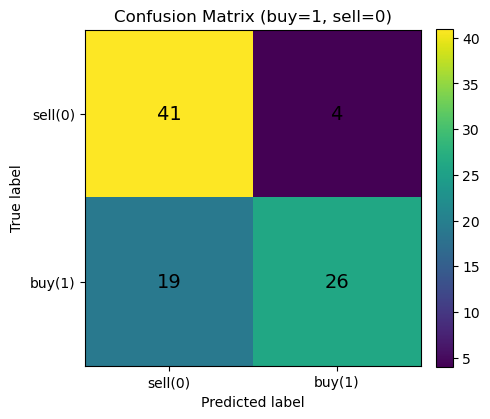


✅ 개별 파일별 예측 결과 저장: C:\Users\bsbcn\Desktop\분류\mlp_eval_result.csv


In [24]:
# ======================================
# 0. 공통 import & 설정
# ======================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt

# 기본 설정
HOME = Path.home()
BASE_DIR = HOME / "Desktop" / "결과_매수매도_학습"
MODEL_NAME = "snunlp/KR-FinBERT-SC"
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("사용 디바이스:", device)

# ======================================
# 1. FinBERT 인코더 + 임베딩 함수
#    (XGBoost 때 쓰던 것과 동일 구조)
# ======================================
print("\n>>> FinBERT 로드 중...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

# 인코더 고정 (freeze)
for p in bert_model.parameters():
    p.requires_grad = False
bert_model.eval()

def get_embeddings(texts, batch_size=32):
    """
    문장 리스트 -> FinBERT CLS 임베딩 (np.array, shape: (N, 768))
    """
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="임베딩 추출 중"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_emb)

    return np.vstack(all_embeddings)

# ======================================
# 2. 학습에 사용했던 SimpleMLP 정의 + best_mlp 로드
#    (네가 준 학습 코드와 완전히 동일 구조)
# ======================================
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=768, num_classes=2):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),   # layers.0
            nn.BatchNorm1d(512),         # layers.1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),         # layers.4
            nn.BatchNorm1d(256),         # layers.5
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_classes)  # layers.8
        )

    def forward(self, x):
        return self.layers(x)

mlp_path = BASE_DIR / "best_mlp.pt"
print(f"\n>>> MLP 모델 로드 중: {mlp_path}")

model_mlp = SimpleMLP().to(device)
state_dict = torch.load(mlp_path, map_location=device)
model_mlp.load_state_dict(state_dict)
model_mlp.eval()

print("✅ best_mlp 로드 완료")

# ======================================
# 3. 폴더에서 텍스트/라벨 로드
#    Desktop/분류/상향 -> buy(1)
#             /하향 -> sell(0)
# ======================================
LABEL_DIR = HOME / "Desktop" / "분류"
BUY_DIR  = LABEL_DIR / "상향"   # label 1
SELL_DIR = LABEL_DIR / "하향"   # label 0

texts = []
y_true = []
filenames = []
true_folder = []

# buy = 1 (상향)
if BUY_DIR.exists():
    for path in sorted(BUY_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(1)
        filenames.append(path.name)
        true_folder.append("buy(상향)")
else:
    print(f"⚠ 상향 폴더가 없습니다: {BUY_DIR}")

# sell = 0 (하향)
if SELL_DIR.exists():
    for path in sorted(SELL_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(0)
        filenames.append(path.name)
        true_folder.append("sell(하향)")
else:
    print(f"⚠ 하향 폴더가 없습니다: {SELL_DIR}")

texts = np.array(texts)
y_true = np.array(y_true)

print(f"\n폴더에서 불러온 샘플 수: {len(texts)}")
if len(texts) == 0:
    raise SystemExit("⚠ 평가할 텍스트가 없습니다. 상향/하향 폴더를 확인하세요.")

# ======================================
# 4. 임베딩 생성 -> MLP 예측
# ======================================
print("\n>>> 폴더 텍스트 임베딩 추출 시작...")
X_emb = get_embeddings(list(texts), batch_size=BATCH_SIZE)   # (N, 768)

X_tensor = torch.from_numpy(X_emb).float().to(device)

all_logits = []
with torch.no_grad():
    for i in range(0, X_tensor.size(0), BATCH_SIZE):
        xb = X_tensor[i:i+BATCH_SIZE]
        logits = model_mlp(xb)         # (B, 2)
        all_logits.append(logits.cpu())

logits = torch.cat(all_logits, dim=0)  # (N, 2)
probs = torch.softmax(logits, dim=1).numpy()
y_pred = probs.argmax(axis=1)

# ======================================
# 5. 성능 지표 출력
# ======================================
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")

print("\n===== MLP 평가 결과 (buy=1, sell=0) =====")
print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}\n")

print("===== 상세 리포트 =====")
print(classification_report(
    y_true, y_pred,
    target_names=["sell(0)", "buy(1)"]
))

buy_mask  = (y_true == 1)
sell_mask = (y_true == 0)
buy_acc   = (y_pred[buy_mask]  == y_true[buy_mask]).mean()  if buy_mask.any()  else np.nan
sell_acc  = (y_pred[sell_mask] == y_true[sell_mask]).mean() if sell_mask.any() else np.nan

if not np.isnan(buy_acc):
    print(f"\nbuy(1) 정확도:  {buy_acc:.4f}")
else:
    print("\nbuy 샘플 없음")

if not np.isnan(sell_acc):
    print(f"sell(0) 정확도: {sell_acc:.4f}")
else:
    print("sell 샘플 없음")

# ======================================
# 6. 혼동행렬 시각화
# ======================================
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix (buy=1, sell=0)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["sell(0)", "buy(1)"])
ax.set_yticklabels(["sell(0)", "buy(1)"])
ax.set_aspect("equal")

for i in range(2):
    for j in range(2):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center", fontsize=14,
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ======================================
# 7. 개별 파일 결과 CSV 저장
# ======================================
df_result = pd.DataFrame({
    "filename": filenames,
    "true_folder": true_folder,
    "true_label": y_true,
    "pred_label": y_pred,
    "prob_sell(0)": probs[:, 0],
    "prob_buy(1)":  probs[:, 1],
})

out_path = LABEL_DIR / "mlp_eval_result.csv"
df_result.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n✅ 개별 파일별 예측 결과 저장: {out_path}")


사용 디바이스: cuda

>>> FinBERT 로드 중: C:\Users\bsbcn\Desktop\결과_매수매도_학습\finbert
✅ FinBERT 로드 완료

폴더에서 불러온 샘플 수: 90

>>> FinBERT 예측 시작...


예측 중: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


===== FinBERT 평가 결과 (buy=1, sell=0) =====
Accuracy : 0.8444
F1-macro : 0.8438

===== 상세 리포트 =====
              precision    recall  f1-score   support

     sell(0)       0.80      0.91      0.85        45
      buy(1)       0.90      0.78      0.83        45

    accuracy                           0.84        90
   macro avg       0.85      0.84      0.84        90
weighted avg       0.85      0.84      0.84        90


buy(1) 정확도:  0.7778
sell(0) 정확도: 0.9111


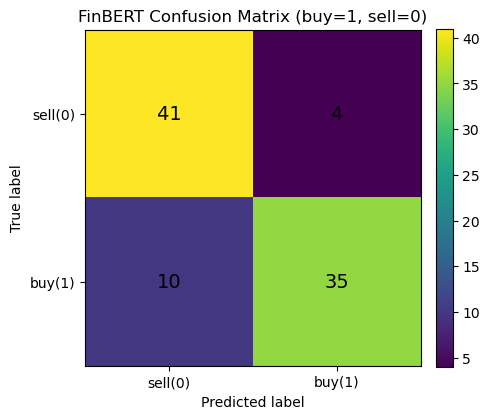


✅ 개별 파일별 예측 결과 저장: C:\Users\bsbcn\Desktop\분류\finbert_eval_result.csv


In [25]:
# -*- coding: utf-8 -*-
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt

# ======================================
# 0. 경로 / 기본 설정
# ======================================
HOME = Path.home()

# 미세조정된 FinBERT 저장 폴더
FINBERT_DIR = HOME / "Desktop" / "결과_매수매도_학습" / "finbert"

# 평가할 텍스트 폴더 (상향=buy=1, 하향=sell=0)
LABEL_DIR = HOME / "Desktop" / "분류"
BUY_DIR  = LABEL_DIR / "상향"   # label 1
SELL_DIR = LABEL_DIR / "하향"   # label 0

BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 디바이스:", device)

# ======================================
# 1. 토크나이저 / FinBERT 분류 모델 로드
# ======================================
print(f"\n>>> FinBERT 로드 중: {FINBERT_DIR}")
tokenizer = AutoTokenizer.from_pretrained(FINBERT_DIR)
model = AutoModelForSequenceClassification.from_pretrained(FINBERT_DIR).to(device)

model.eval()
print("✅ FinBERT 로드 완료")

# ======================================
# 2. 상향/하향 폴더에서 텍스트 & 라벨 로드
#    상향 -> buy(1), 하향 -> sell(0)
# ======================================
texts = []
y_true = []
filenames = []
true_folder = []

# buy = 1
if BUY_DIR.exists():
    for path in sorted(BUY_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(1)
        filenames.append(path.name)
        true_folder.append("buy(상향)")
else:
    print(f"⚠ 상향 폴더 없음: {BUY_DIR}")

# sell = 0
if SELL_DIR.exists():
    for path in sorted(SELL_DIR.glob("*.txt")):
        with open(path, "r", encoding="utf-8") as f:
            txt = f.read().strip()
        if not txt:
            continue
        texts.append(txt)
        y_true.append(0)
        filenames.append(path.name)
        true_folder.append("sell(하향)")
else:
    print(f"⚠ 하향 폴더 없음: {SELL_DIR}")

texts = np.array(texts)
y_true = np.array(y_true)

print(f"\n폴더에서 불러온 샘플 수: {len(texts)}")
if len(texts) == 0:
    raise SystemExit("⚠ 평가할 텍스트가 없습니다. 상향/하향 폴더를 확인하세요.")

# ======================================
# 3. FinBERT로 배치 인퍼런스 (직접 분류)
# ======================================
all_logits = []

print("\n>>> FinBERT 예측 시작...")
for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="예측 중"):
    batch_texts = texts[i:i+BATCH_SIZE]

    inputs = tokenizer(
        list(batch_texts),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)           # logits: (B, 2)
        logits = outputs.logits.cpu()
        all_logits.append(logits)

logits = torch.cat(all_logits, dim=0)       # (N, 2)
probs = torch.softmax(logits, dim=1).numpy()
y_pred = probs.argmax(axis=1)

# ======================================
# 4. 성능 지표 출력
# ======================================
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")

print("\n===== FinBERT 평가 결과 (buy=1, sell=0) =====")
print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}\n")

print("===== 상세 리포트 =====")
print(classification_report(
    y_true, y_pred,
    target_names=["sell(0)", "buy(1)"]
))

buy_mask  = (y_true == 1)
sell_mask = (y_true == 0)
buy_acc   = (y_pred[buy_mask]  == y_true[buy_mask]).mean()  if buy_mask.any()  else np.nan
sell_acc  = (y_pred[sell_mask] == y_true[sell_mask]).mean() if sell_mask.any() else np.nan

if not np.isnan(buy_acc):
    print(f"\nbuy(1) 정확도:  {buy_acc:.4f}")
else:
    print("\nbuy 샘플 없음")

if not np.isnan(sell_acc):
    print(f"sell(0) 정확도: {sell_acc:.4f}")
else:
    print("sell 샘플 없음")

# ======================================
# 5. 혼동행렬 시각화
# ======================================
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("FinBERT Confusion Matrix (buy=1, sell=0)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["sell(0)", "buy(1)"])
ax.set_yticklabels(["sell(0)", "buy(1)"])
ax.set_aspect("equal")

for i in range(2):
    for j in range(2):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center", fontsize=14,
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ======================================
# 6. 파일별 결과 CSV 저장
# ======================================
df_result = pd.DataFrame({
    "filename": filenames,
    "true_folder": true_folder,
    "true_label": y_true,
    "pred_label": y_pred,
    "prob_sell(0)": probs[:, 0],
    "prob_buy(1)":  probs[:, 1],
})

out_path = LABEL_DIR / "finbert_eval_result.csv"
df_result.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n✅ 개별 파일별 예측 결과 저장: {out_path}")



===== FinBERT (Threshold 0.40, buy=1, sell=0) =====
Accuracy : 0.8556
F1-macro : 0.8551

===== 상세 리포트 =====
              precision    recall  f1-score   support

     sell(0)       0.82      0.91      0.86        45
      buy(1)       0.90      0.80      0.85        45

    accuracy                           0.86        90
   macro avg       0.86      0.86      0.86        90
weighted avg       0.86      0.86      0.86        90


buy(1) 정확도:  0.8000
sell(0) 정확도: 0.9111


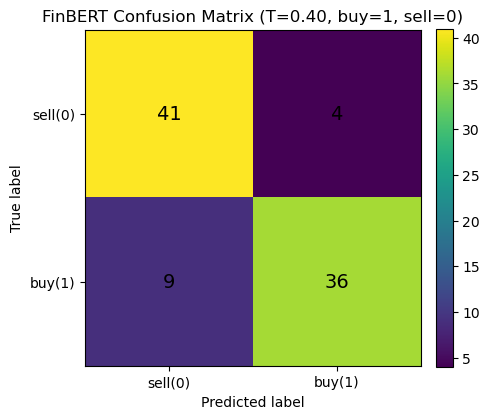

In [30]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import torch

# ======================================
# 1) Threshold 기반 예측 (buy=1, sell=0)
# ======================================
probs = torch.softmax(logits, dim=1).numpy()   # (N, 2)

threshold = 0.40  # ★ 여기 숫자 조절하면서 10/35 → 7/38 근처로 맞춰봐
y_pred = (probs[:, 1] >= threshold).astype(int)  # P(buy) >= T → 1, 아니면 0

# ======================================
# 2) 성능 지표 출력
# ======================================
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")

print("\n===== FinBERT (Threshold {:.2f}, buy=1, sell=0) =====".format(threshold))
print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}\n")

print("===== 상세 리포트 =====")
print(classification_report(
    y_true, y_pred,
    target_names=["sell(0)", "buy(1)"]
))

# 클래스별 정확도
buy_mask  = (y_true == 1)
sell_mask = (y_true == 0)
buy_acc   = (y_pred[buy_mask]  == y_true[buy_mask]).mean()  if buy_mask.any()  else np.nan
sell_acc  = (y_pred[sell_mask] == y_true[sell_mask]).mean() if sell_mask.any() else np.nan

if not np.isnan(buy_acc):
    print(f"\nbuy(1) 정확도:  {buy_acc:.4f}")
else:
    print("\nbuy 샘플 없음")

if not np.isnan(sell_acc):
    print(f"sell(0) 정확도: {sell_acc:.4f}")
else:
    print("sell 샘플 없음")

# ======================================
# 3) 혼동행렬 시각화
# ======================================
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title(f"FinBERT Confusion Matrix (T={threshold:.2f}, buy=1, sell=0)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["sell(0)", "buy(1)"])
ax.set_yticklabels(["sell(0)", "buy(1)"])
ax.set_aspect("equal")

# 셀 숫자 찍기
for i in range(2):
    for j in range(2):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center", fontsize=14,
        )

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
